# EV State-Space Model

This  notebook is used to reproduce the State Space Model of aggregateed EV for frequQcy regulation.

## Parameters

The EV parameters are defined as two types: parameters that follow uniform distribution are stored in ``ev_ufparam``, and parameters that follow normal distribution are stored in ``ev_nfparam``.

Reference:

1. M. Wang et al., "State Space Model of Aggregated Electric Vehicles for Frequency Regulation," in IEEE Transactions on Smart Grid, vol. 11, no. 2, pp. 981-994, March 2020, doi: 10.1109/TSG.2019.2929052.

State space model of EV aggregator:

$ \mathbf{x}(k+1) = \mathbf{A} \mathbf{x}(k) + \mathbf{B} \mathbf{u}(k) + \mathbf{C} \mathbf{v}(k) $

$ \mathbf{y}(k) = \mathbf{D} \mathbf{x}(k)$

In this form, control action $\mathbf{B} \mathbf{u}(k) + \mathbf{C} \mathbf{v}(k)$ will directly take effect on $\mathbf{x}(k+1)$. However, the control action should be effective after the function of $\mathbf{A}$. As a result, the SSM should be revised as:

$ \mathbf{x}(k+1) = \mathbf{A} \left( \mathbf{x}(k) + \mathbf{B} \mathbf{u}(k) + \mathbf{C} \mathbf{v}(k) \right) $

$ \mathbf{y}(k) = \mathbf{D} \mathbf{x}(k) $

$ \mathbf{D} = P_{ave} N_{e} [-\mathbf{1}_{1 \times N_s}, \mathbf{0}_{1 \times N_s}, \mathbf{1}_{1 \times N_s}] $

Output of a), C to I:

$ \mathbf{D_a} = P_{ave} N_{e} [\mathbf{0}_{1 \times N_s}, \mathbf{0}_{1 \times N_s}, \mathbf{1}_{1 \times N_s}] $


Output of b), I to D

$ \mathbf{D_b} = P_{ave} N_{e} [\mathbf{1}_{1 \times N_s}, \mathbf{1}_{1 \times N_s}, \mathbf{1}_{1 \times N_s}] $


Output of c), D to I

$ \mathbf{D_c} = P_{ave} N_{e} [-\mathbf{1}_{1 \times N_s}, \mathbf{0}_{1 \times N_s}, \mathbf{0}_{1 \times N_s}] $

Output of d), I to C

$ \mathbf{D_d} = P_{ave} N_{e} [-\mathbf{1}_{1 \times N_s}, -\mathbf{1}_{1 \times N_s}, -\mathbf{1}_{1 \times N_s}] $

## EV SSM Class

In [1]:
import itertools
from tqdm import tqdm
import pandas as pd
import numpy as np
import scipy.stats as stats
from hmmlearn import hmm
import matplotlib.pyplot as plt

import logging
logger = logging.getLogger(__name__)


def find_x(x, soc_intv):
    out = -1
    for idx in soc_intv.keys():
        if x > soc_intv[idx][0] and x <= soc_intv[idx][1]:
            out = idx
    return out


def update_xl(inl_input):
    """
    Update x series.
    columns:
    ['sx', 'xl', 'u', 'u0', 'c2', 'ts', 'c0', 'bd']
      0,    1,    2,   3,    4,    5    6,    7
    """
    [sx, xl0, u, u0, c2, ts, c0, bd] = inl_input.copy()
    xl = xl0.copy()
    case1 = (u*u0 == 1) & (c2 == c0)  # --- cont. online & same c ---
    case2 = (u*u0 == 1) & (c2 != c0) & (bd == 1)  # --- cont. online & change c by boundary ---
    case3 = (u*u0 == 1) & (c2 != c0) & (bd == 0)  # --- cont. online & change c by control ---
    case4 = (1-u0)*u == 1  # offline -> online

    if case1 | case2:
        if len(xl[0]) == 0:
            xl[0] = [[c2]]
            xl[1] = [[sx]]
            xl[2] = [[ts]]
        else:
            xl[0][-1].append(c2)
            xl[1][-1].append(sx)
            xl[2][-1].append(ts)
    elif case3 | case4:
        if len(xl[0]) == 0:
            xl[0] = [[c2]]
            xl[1] = [[sx]]
            xl[2] = [[ts]]
        else:
            xl[0].append([c2])
            xl[1].append([sx])
            xl[2].append([ts])
    return xl


def safe_div(x, y):
    if y == 0:
        return 0
    else:
        return x/y


class ev_ssm():
    """
    EV State Space Model.

    EV parameters:
    Pc, Pd, nc, nd, Q follow uniform distribution.
    soci, socd, ts, tf follows normal distribution.

    Attributes
    ----------
    xtab: pandas.DataFrame
        EV states table, only online EVs are counted.
    ne: int
        Number of online EVs
    N: int
        Number of total EVs
    Np: int
        SSM update cycle.
    ev: pandas.DataFrame
        EV dataset
        u: online status
        u0: previous online status
        sx: SOC interval
        xl: list of lists, [[states], [sx], [t]]
    ts: float
        current time (unit: 24H)

    Notes
    -----
    ev_ufparam:
        Pl: rated charging/discharging power (kW) lower bound
        Pu: rated charging/discharging power (kW) upper bound
        nl: charging/discharging efficiency lower bound
        nu: charging/discharging efficiency upper bound
        Ql: Battery capacity (kWh) lower bound
        Qu Battery capacity (kWh) upper bound
        socl: Minimum SoC value
        socu: Maximum SoC value
    ev_nfparam:
        soci: initial SoC
        socd: demanded SoC
        ts1: start charging time, [24H]
        ts2: start charging time, [24H]
        tf1: finish charging time, [24H]
        tf2: finish charging time, [24H]
    """

    def find_sx(self):
        self.ev['sx'] = self.ev['soc'].apply(lambda x: find_x(x, self.soc_intv))

    def report(self, is_report=True):
        """
        Report EVA.
        """
        # --- EV summary info ---
        self.Q = self.ev.Q.sum()/1e3
        self.ev['wEn'] = self.ev['Q'] * self.ev['u']
        self.wEn = self.ev.wEn.sum()/1e3
        self.ev['wsoc'] = self.ev['soc'] * self.ev['Q'] * self.ev['u']
        self.wsoc = self.ev['wsoc'].sum() / self.wEn / 1e3
        self.ev['Ps'] = self.ev[['Pc', 'c', 'Pd', 'u']].apply(
            lambda x: x[0]*x[1]*x[3] if x[1] >= 0 else x[2]*x[1]*x[3], axis=1)
        self.Pc = -1 * self.ev.Ps[self.ev.Ps >= 0].sum()/1e3
        self.Pd = -1 * self.ev.Ps[self.ev.Ps <= 0].sum()/1e3
        self.Pt = -1 * self.ev.Ps.sum()/1e3
        self.ev.drop(columns=['wEn', 'wsoc', 'Ps'], inplace=True)

        if is_report:
            # --- report info ---
            msg_time = f'{self.name}: ts={np.round(self.ts, 4)}[H], {self.N} EVs, Total Q={self.Q.round(2)} MWh\n'
            msg_soc = f"Online {self.ne}, Q={self.wEn.round(2)} MWh, SoC={self.wsoc.round(4)}\n"
            msg_p = f"G(MW): Pt={self.Pt.round(4)}, Pc={self.Pc.round(4)}, Pd={self.Pd.round(4)}"
            logger.warning(msg_time + msg_soc + msg_p)

    def g_ts(self, ts):
        """
        Update time and time series.
        """
        if abs(ts - self.ts) < self.step/3600:
            logger.warning(f"{self.name}: {ts}[H] is too close to current time={self.ts}[H]")
        else:
            self.tss.append(ts)
            ts = ts if ts < 24 else ts-24
        return ts

    def __init__(self, ts=0, N=20000, step=4, tp=100,
                 lr=0.1, lp=100, seed=None, name="EVA"):
        """
        Parameters
        ----------
        ts: float
            Current time in hour, [0, 24].
        N: int
            Number of EVs
        tp: int
            SSM update period (second).
        lr: float
            learning rate of updating SSM A
        lp: int
            SSM update length, data length for update A.
        step: int
            Step size in seconds.
        seed: int
            Random seed. ``None`` for random.
        """
        # --- 1. init ---
        self.name = name
        self.N = N
        self.step = step
        self.tp = tp
        self.Np = int(tp / step)  # update cycle
        self.lr = lr
        self.lp = lp
        self.seed = seed
        np.random.seed(self.seed)
        # --- 1a. uniform distribution parameters range ---
        self.ev_ufparam = dict(Ns=20,
                               Pl=5.0, Pu=7.0,
                               nl=0.88, nu=0.95,
                               Ql=20.0, Qu=30.0,
                               socl=0, socu=1)
        #  --- 1b. normal distribution parameters range ---
        self.ev_pdf_name = ['soci', 'socd', 'ts1', 'ts2', 'tf1', 'tf2']
        self.ev_pdf_data = {'mean':     [0.3,    0.8,    -6.5,  17.5,   8.9,  32.9],
                            'var':      [0.05,   0.03,   3.4,   3.4,    3.4,  3.4],
                            'lb':       [0.2,    0.7,    0.0,   5.5,    0.0,  20.9],
                            'ub':       [0.4,    0.9,    5.5,   24.0,   20.9, 24.0],
                            'info':  ['initial SoC', 'demanded SoC',
                                      'start charging time 1', 'start charging time 2',
                                      'finish charging time 1', 'finish charging time 2']}
        self.ts = ts
        self.tss = [ts]
        self.build(ts=ts)
        self.nel = [self.ne]
        self.report()

        self.Ptl = [self.Pt]
        self.Pcl = [self.Pc]
        self.Pdl = [self.Pd]

        # --- SSM ---
        # --- input: AGC signal ---

        # --- output: estimated FRC ---
        self.prumax = 0
        self.prdmax = 0

    def build(self, ts):
        """
        Build the ev DataFrame.

        Returns
        -------
        ev: pandas.DataFrame
            EV dataset
        """
        self.socl = self.ev_ufparam['socl']
        self.socu = self.ev_ufparam['socu']

        # --- soc charging/dicharging boundary ---
        self.sl = 0.005
        self.su = 0.995

        #  --- 1a. uniform distribution parameters range ---
        unit = self.ev_ufparam['socu']/self.ev_ufparam['Ns']
        self.soc_intv = {}
        decimal = 4
        for i in range(self.ev_ufparam['Ns']):
            intv_single = [np.around(i*unit, decimal), np.around((i+1)*unit, decimal)]
            self.soc_intv[i] = intv_single
        self.Ns = self.ev_ufparam['Ns']
        ev_pdf = pd.DataFrame(data=self.ev_pdf_data, index=self.ev_pdf_name).transpose()
        self.ev_nfparam = ev_pdf.to_dict()

        # --- 1c. generate EV dataset ---
        self.ev = pd.DataFrame()

        #  data from uniform distribution
        cols = ['Pc', 'Pd', 'nc', 'nd', 'Q']
        cols_bound = {'Pc':   ['Pl', 'Pu'],
                      'Pd':   ['Pl', 'Pu'],
                      'nc':   ['nl', 'nu'],
                      'nd':   ['nl', 'nu'],
                      'Q':    ['Ql', 'Qu']}
        for col in cols:
            idxl = cols_bound[col][0]
            idxh = cols_bound[col][1]
            self.ev[col] = np.random.uniform(
                low=self.ev_ufparam[idxl],
                high=self.ev_ufparam[idxh],
                size=self.N)

        #  data from normal distribution
        # soci, socd
        for col in self.ev_pdf_name:
            self.ev[col] = stats.truncnorm(
                (ev_pdf[col]['lb'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'],
                (ev_pdf[col]['ub'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'],
                loc=ev_pdf[col]['mean'], scale=ev_pdf[col]['var']).rvs(self.N)

        # ts1, ts2, tf1, tf2
        et = self.ev.copy()
        r1 = 0.5  # ratio of t1
        tp1 = self.ev[['ts1', 'tf1']].sample(n=int(et.shape[0]*r1), random_state=2021)
        tp2 = self.ev[['ts2', 'tf2']].sample(n=int(et.shape[0]*(1-r1)), random_state=2021)
        tp = pd.concat([tp1, tp2], axis=0).reset_index(drop=True).fillna(0)
        tp['ts'] = tp['ts1'] + tp['ts2']
        tp['tf'] = tp['tf1'] + tp['tf2']
        check = tp.ts > tp.tf
        row_idx = tp[check].index
        mid = tp.tf.iloc[row_idx].values
        tp.tf.iloc[row_idx] = tp.ts.iloc[row_idx]
        tp.ts.iloc[row_idx] = mid
        check = tp.ts > tp.tf
        self.ev['ts'] = tp['ts']
        self.ev['tf'] = tp['tf']
        self.ev['u'] = 1

        # Initialize delta power
        self.ev['dP'] = 0

        self.states = list(itertools.product([1, 0, -1], self.soc_intv.keys()))
        self.states_str = [str(s[1])+'S'+str(s[0]) for s in self.states]

        # --- update soc interval and online status ---
        # soc is initialzied considering random behavior
        self.ev['soc'] = self.ev[['soci', 'ts', 'Pc', 'nc', 'Q', 'tf']].apply(
            lambda x: x[0] + (min(ts-x[1], x[5]-x[1]))*x[2]*x[3]/x[4] if ts > x[1] else x[0], axis=1)
        self.ev['soc'] = self.ev['soc'].apply(lambda x: min(x, self.socu))
        self.ev['soc'] = self.ev['soc'].apply(lambda x: max(x, self.socl))
        self.ev['bd'] = self.ev.soc.apply(lambda x: 1 if (x <= self.sl) | (x >= self.su) else 0)

        # --- ev online status: u0 as u ---
        self.ev['u0'] = 0
        self.g_u()
        self.ev['u0'] = self.ev.u

        # Initiallize control signal, randomly assign c/dc
        self.ev['c'] = 0
        self.ev['c2'] = 0
        self.g_c()

        self.find_sx()
        self.g_x()
        self.r_state()

        # initialize x series
        self.ev['xl'] = [[[], [], []]] * self.N
        self.ne = self.ev.u.sum()

        ev_cols = ['u', 'u0',  'soc', 'bd', 'c', 'c2', 'c0', 'sx', 'dP', 'xl',
                   'soci', 'socd', 'Pc', 'Pd', 'nc', 'nd', 'Q', 'ts', 'tf', ]
        self.ev = self.ev[ev_cols]

        self.g_BCD()

        self.n_step = 1
        return True

    def g_u(self):
        """
        Update online status of EV at given time.
        """
        # --- online status ---
        self.ev['u0'] = self.ev.u.astype(int)
        self.ev['u'] = (self.ev.ts <= self.ts) & (self.ev.tf >= self.ts)
        self.ev['u'] = self.ev['u'].astype(int)
        self.ne = self.ev.u.sum()
        return True

    def g_x(self):
        """
        Update EV x and SSM x.

        In the output table, columns stand for soc interval, rows stand for charging status.

        0 for charging, 1 for idle, 2 for discharging.

        Returns
        -------
        xtab: pd.DataFrame
            Table of SSM status of *online* EVs
        rtab: pd.DataFrame
            Table of SSM status of *online* EVs, by percentage
        """
        # --- find single EV sx ---
        self.ev['sx'] = self.ev['soc'].apply(lambda x: find_x(x, self.soc_intv))

        # --- find SSM X ---
        states = self.ev[['c2', 'sx', 'u']].apply(lambda x: (x[0], x[1]) if x[2] else (-1, -1), axis=1)
        res = dict(states.value_counts())
        self.xtab = pd.DataFrame(columns=range(self.Ns), index=[0, 1, 2], data=0)
        for key in res.keys():
            if key[1] > -1:
                self.xtab.loc[key[0], key[1]] = res[key]
        self.xtab.fillna(0, inplace=True)

        self.rtab = self.xtab.div(self.ne)
        return True

    def save_A(self, csv):
        """
        Save A matrix to csv file.

        Parametes
        ---------
        csv: str
            csv file name.
        """
        As = pd.DataFrame(data=self.A)
        As.to_csv(csv, index=False)
        logger.warning(f'{self.name}: Save A to %s.' % csv)
        return True

    def load_A(self, csv):
        """
        Load A matrix from csv files.

        Warning: load A from csv files will overwrite existing A!

        Parametes
        ---------
        csv: str
            csv file name.
        """
        self.A = pd.read_csv(csv).values
        logger.warning(f'{self.name}: Load A from %s.' % csv)

    def plot(self, figsize=(6, 3)):
        """
        Plot the results.
        """
        plt.style.use('default')
        with plt.style.context(['ieee']):
            fig, ax = plt.subplots(1, 1, figsize=figsize)
            p1 = ax.plot(self.tss, self.Ptl, label="Total")
            p2 = ax.plot(self.tss, self.Pcl, label="Charging")
            p3 = ax.plot(self.tss, self.Pdl, label="Discharging")
            ax2 = ax.twinx()
            p4 = ax2.plot(self.tss, self.nel, label='Online EVs', color='orange')
            ax2.set_ylabel("Number")

            ax.set_xlabel("Time [H]")
            ax.set_ylabel("Power (MW)")
            ax.set_title(f"{sse.name}")
            ax.set_xlim(sse.tss[0], sse.tss[-1])
            ax.grid()

            lns = p1 + p2 + p3 + p4
            labels = [l.get_label() for l in lns]
            plt.legend(lns, labels)
        return fig, ax

    def test(self, tf=9.05):
        """
        Build the matrix A with test ev data.

        During the test, the EV behaviors and controls will be uniformed.
        After the test, the EV will be reset to initial states.

        Parameters
        ----------
        ts: float
            start time [H]
        tf: float
            end time [H]
        """
        t_step = self.step / 3600
        ev_cols = ['u', 'u0', 'soc', 'sx', 'bd',
                   'ts', 'tf', 'c', 'c0', 'dP', 'c2']
        ev_copy = self.ev[ev_cols].copy()

        self.ev['tf'] = 23.9
        self.ev['ts'] = 0.1
        self.ev['soc'] = np.random.uniform(low=0.001, high=0.999, size=self.N)
        self.g_u()

        # initialize contro signal: randomly assign C/I/D
        self.ev['c'] = np.random.choice([-1, 0, 1], p=[0.33, 0.33, 0.34], size=self.N)
        # revise
        # offline -> I
        self.ev['c'] = self.ev[['u', 'c']].apply(lambda x: x[1] if x[0] != 0 else 0, axis=1)
        # sl, DC -> C
        self.ev['c'] = self.ev[['u', 'c', 'soc']].apply(
            lambda x: 1 if (x[2] < self.sl) & (x[1] == -1) else x[1], axis=1)
        # su, C -> I
        self.ev['c'] = self.ev[['u', 'c', 'soc']].apply(
            lambda x: 1 if (x[2] > self.su) & (x[1] == 1) else x[1], axis=1)

        for t in tqdm(np.arange(self.ts+t_step, tf, t_step), desc=f'{self.name} MCS'):
            self.ts = self.g_ts(t)
            self.g_u()  # update online status
            self.g_c(is_test=True)  # update control signal
            # --- update soc interval and online status ---
            # charging/discharging power, kW
            self.ev['dP'] = self.ev[['Pc', 'Pd', 'nc', 'nd', 'c', 'u']].apply(
                lambda x: x[0]*x[2]*x[5]*x[4] if x[4] >= 0 else x[1]*x[3]*x[5]*x[4], axis=1)
            # --- update and modify SoC ---
            self.ev['soc'] = self.ev.soc + t_step * self.ev['dP'] / self.ev['Q']
            self.ev['soc'] = self.ev['soc'].apply(lambda x: x if x < self.socu else self.socu)
            self.ev['soc'] = self.ev['soc'].apply(lambda x: x if x > self.socl else self.socl)
            self.ev['soc'] = self.ev.soc + t_step * self.ev['dP'] / self.ev['Q']
            # --- boundary ---
            self.ev['bd'] = self.ev.soc.apply(lambda x: 1 if (x <= self.sl) | (x >= self.su) else 0)

            # record control signal
            self.ev['c2'] = self.ev['c'].replace({1: 0, 0: 1, -1: 2})
            self.ev['c0'] = self.ev['c2']
            # update control signal
            # offline -> I
            self.ev['c'] = self.ev[['u', 'c']].apply(lambda x: x[1] if x[0] != 0 else 0, axis=1)
            # sl, DC -> C
            self.ev['c'] = self.ev[['u', 'c', 'soc']].apply(
                lambda x: 1 if (x[2] < self.sl) & (x[1] == -1) else x[1], axis=1)
            # su, C -> I
            self.ev['c'] = self.ev[['u', 'c', 'soc']].apply(
                lambda x: 1 if (x[2] > self.su) & (x[1] == 1) else x[1], axis=1)

            # --- update x ---
            self.find_sx()
            self.g_x()
            self.g_xl()

        # build A matrix
        self.g_A()

        # reset EV data
        self.ev[ev_cols] = ev_copy[ev_cols]
        # self.reset(ts0, clean_xl=False)

    def run(self, tf=10, is_update=False, is_record=False, is_test=False):
        """
        Run the ev aggregator from ``ts`` to ``tf``.

        Parameters
        ----------
        tf: int
            end time [H].
        is_update: bool
            `True` for updating SSM A during the simulation, False for not.
            Set `is_g_SSM=True` will record EV status.
        is_record: bool
            `True` for recording the EV status in a series, False for not recording.
            Set `is_record=False` can speed up the simulation.
        is_test: bool
            `g_c` control mode
        """
        t_step = self.step / 3600
        if tf - self.ts < 1e-5:
            logger.warning(f"{self.name}: end time {tf}[H] is too close to start time {self.ts}[H],"
                           "simulation will not start.")
        else:
            for t in tqdm(np.arange(self.ts+t_step, tf, t_step), desc=f'{self.name} MCS'):
                # --- update SSM A ---
                if is_update:
                    if self.n_step % self.Np == 0:
                        self.g_A(is_update=True)
                        self.r_state()

                self.ts = self.g_ts(t)
                self.g_u()  # update online status
                self.g_c(is_test=is_test)  # update control signal

                # --- update soc interval and online status ---
                # charging/discharging power, kW
                self.ev['dP'] = self.ev[['Pc', 'Pd', 'nc', 'nd', 'c', 'u']].apply(
                    lambda x: x[0]*x[2]*x[5] if x[4] >= 0 else -1*x[1]*x[3]*x[5], axis=1)
                # --- update and modify SoC ---
                self.ev['soc'] = self.ev.soc + t_step * self.ev['dP'] / self.ev['Q']
                self.ev['soc'] = self.ev['soc'].apply(lambda x: x if x < self.socu else self.socu)
                self.ev['soc'] = self.ev['soc'].apply(lambda x: x if x > self.socl else self.socl)

                # --- update x ---
                self.find_sx()
                self.g_x()

                if is_record | is_update:
                    self.g_xl()

                # record power
                self.report(is_report=False)
                self.Ptl.append(self.Pt)
                self.Pcl.append(self.Pc)
                self.Pdl.append(self.Pd)
                self.nel.append(self.ne)

                self.n_step += 1

    def g_A(self, is_update=False):
        """
        Compute A matrix: cols: x(k), row: x(k+1)
        The sum of col should be 1.
        """
        # --- gather results ---
        states = []
        ctrls = []
        for item in self.ev.xl.tolist():
            if len(item[0]) > 0:
                states.append(item[1][0])
                ctrls.append(item[0][0])
        data = []
        for x, y in zip(ctrls, states):
            data0 = []
            for c, s in zip(x, y):
                rx = c * self.Ns + s
                data0.append(rx)
            data.append(data0)

        A0 = np.zeros((3*self.Ns, 3*self.Ns))
        for d in data:
            for i in range(len(d)-1):
                A0[d[i+1], d[i]] += 1

        if is_update:
            n = int(self.lr / (1-self.lr))
            A0 = self.A * len(data) * n * np.ones((60,))
            self.A = self.A + A0
            row_sum = self.A.sum(axis=0)
            self.A = self.A / row_sum
        else:
            row_sum = A0.sum(axis=0)
            self.A = A0 / row_sum

    def g_xl(self):
        """
        Update EV x series.
        """
        self.ev['tnow'] = self.ts
        col = ['sx', 'xl', 'u', 'u0', 'c2', 'tnow', 'c0', 'bd']
        self.ev['xl'] = self.ev[col].apply(update_xl, axis=1)
        self.ev.drop(['tnow'], axis=1, inplace=True)
        return True

    def g_c(self, is_test=False):
        """
        Generate the charging signal. `is_test=True` is recommended for initially building SSM A.

        Parameters
        ----------
        is_test: bool
            `True` for test mode, `False` for normal mode.
            normal mode: ``CS`` for online EVs
            test mode: only revise control signal
        """
        # record last ctrl signal
        self.ev['c0'] = self.ev['c2']

        if is_test:
            pass
        else:
            # TODO: replace with SSM later on
            # default: online -> charge
            self.ev['c'] = self.ev['u']
        # --- revise control ---
        # `CS` for low charged EVs
        self.ev['c'] = self.ev[['soc', 'c']].apply(
            lambda x: 1 if x[0] <= self.sl else x[1], axis=1)
        # `IS` for high charged EVs
        self.ev['c'] = self.ev[['soc', 'c', 'socd']].apply(
            lambda x: 0 if x[0] >= self.su else x[1], axis=1)
        # `IS` for offline EVs
        self.ev['c'] = self.ev[['c', 'u']].apply(
            lambda x: x[0]*x[1], axis=1)
        # reformat to [0, 1, 2]
        self.ev['c2'] = self.ev['c'].replace({1: 0, 0: 1, -1: 2})
        # format
        self.ev[['c', 'c2', 'c0']] = self.ev[['c', 'c2', 'c0']].astype(int)

    def g_res(self, x0, n=1):
        """
        Estimate the EV_SSM status, stores in attribute pd.DataFrame ``res``

        Parameters
        ----------
        x0: numpy.array, (60, )
            [CS, DS, IS], initial distribution of states.
        n: int
            number of steps.

        Returns
        -------
        xr: numpy.array, (60, )
            [CS, DS, IS], initial distribution of states.
        etab: pd.DataFrame
            the estimated states of the next n steps.
        """
        if not hasattr(self, 'A'):
            raise ValueError("Matrix A is not defined")
        # --- out ---
        for i in range(n):
            x0 = np.matmul(self.A, x0)
        self.xr = x0
        self.etab = pd.DataFrame(data=x0.reshape(3, 20),
                                 columns=range(20),
                                 index=range(3))

    def reset(self, tnow=10, clean_xl=False):
        """
        Reset the pd.DataFrame ``ev`` to the initial time.

        Parameters
        ----------
        tnow: int
            the current time [H].
        clean_xl: bool
            `True` to clean `ev['xl']`, `False` to keep it.
        """
        if tnow:
            self.tss = [tnow]
            self.ts = self.tss[0]
        else:
            self.tss = [self.tss[0]]
            self.ts = self.tss[0]
        col = ['u', 'u0',  'soc', 'bd', 'c', 'c2', 'c0', 'sx', 'dP', 'xl',
               'soci', 'socd', 'Pc', 'Pd', 'nc', 'nd', 'Q', 'ts', 'tf']
        self.ev = self.ev[col]
        self.ev['c2'] = self.ev['c'].replace({1: 0, 0: 1, -1: 2})
        self.ev['dP'] = 0
        if clean_xl:
            self.ev['xl'] = [[[], [], []]] * self.N
        self.ev['u0'] = 0
        self.g_u()
        self.ev['u0'] = self.ev.u

        self.find_sx()
        self.g_x()
        self.r_state()
        self.ne = self.ev.u.sum()
        self.n_step = 1
        logger.warning(f"{self.name}: Reset to {self.ts}[H]")
        self.report()
        self.Ptl = [self.Pt]
        self.Pcl = [self.Pc]
        self.Pdl = [self.Pd]
        self.nel = [self.ne]

    def r_state(self):
        """
        Record the states distribution of online EVs from `rtab`.

        Returns
        -------
        x0: np.array
            states distribution (60, ) [CS, IS, DS]
        """
        if hasattr(self, 'rtab'):
            self.x0 = self.rtab.values.reshape(-1,)
        else:
            self.x0 = np.zeros(60,)
            logger.warning(f"{self.name}: 'rtab' is not available!")
        return self.x0

    def cp(self):
        """
        Analytical output power (MW).
        Total, charge, discharge, upper, lower

        Returns
        -------
        out: list of float
            [Pt, Pc, Pd, Pu, Pl] (MW)
        """
        self.ev['Ps'] = self.ev[['Pc', 'c', 'Pd']].apply(lambda x: x[0]*x[1] if x[1] >= 0 else x[2]*x[1], axis=1)
        Pt = - self.ev['Ps'].sum()
        Pc = - self.ev['Ps'][self.ev['Ps'] > 0].sum()
        Pd = self.ev['Ps'][self.ev['Ps'] < 0].sum()
        Pl = - self.ev[self.ev.u == 1]['Pc'].sum()
        Pu = self.ev[self.ev.u == 1]['Pd'].sum()

        self.ev.drop(['Ps'], axis=1, inplace=True)

        out = [Pt, Pu, Pl, Pc, Pd]
        out = [x/1000 for x in out]  # kW to MW
        return out

    def ep(self):
        """
        Estimate output power (MW).
        Total, upper, lower

        Returns
        -------
        out: list of float
            [Pt, Pu, Pl] (MW)
        """
        Pt = np.matmul(self.ne * self.D, sse.x0)[0]
        Pu = np.matmul(self.ne * self.Db, sse.x0)[0]
        Pl = np.matmul(self.ne * self.Dd, sse.x0)[0]
        Pa = self.ne * np.matmul(self.Da - self.D, sse.x0)[0]
        Pb = self.ne * np.matmul(self.Db - self.Da, sse.x0)[0]
        Pc = self.ne * np.matmul(self.Dc - self.D, sse.x0)[0]
        Pd = self.ne * np.matmul(self.Dd - self.Dc, sse.x0)[0]
        out = [Pt, Pu, Pl, Pa, Pb, Pc, Pd]
        return out

    def g_BCD(self):
        """
        Build SSM B, C, D matrix.
        The output of EVA (MW) can be calculated by: `ne * D * x0`.
        """
        # --- B ---
        B1 = -1 * np.eye(self.Ns)
        B2 = np.eye(self.Ns)
        B3 = np.zeros((self.Ns, self.Ns))
        self.B = np.vstack((B1, B2, B3))

        # --- C ---
        C1 = np.zeros((self.Ns, self.Ns))
        C2 = -1 * np.eye(self.Ns)
        C3 = np.eye(self.Ns)
        self.C = np.vstack((C1, C2, C3))

        # --- D ---
        kde = stats.gaussian_kde(self.ev.Pc)
        Pave = 0  # P average
        step = 0.01
        # TODO: also consider Pd?
        for Pl in np.arange(self.ev.Pc.min(), self.ev.Pc.max(), step):
            Pave += (kde.integrate_box(Pl, Pl+step)) * (Pl + 0.005 * step)
        Pave = Pave / 1000  # kW to MW
        D1 = -1 * np.ones((1, self.Ns))
        D2 = np.zeros((1, self.Ns))
        D3 = np.ones((1, self.Ns))
        self.D = Pave * np.hstack((D1, D2, D3))

        # --- D a,b,c,d ---
        D1 = np.zeros((1, self.Ns))
        D2 = np.zeros((1, self.Ns))
        D3 = np.ones((1, self.Ns))
        self.Da = Pave * np.hstack((D1, D2, D3))

        D1 = np.ones((1, self.Ns))
        D2 = np.ones((1, self.Ns))
        D3 = np.ones((1, self.Ns))
        self.Db = Pave * np.hstack((D1, D2, D3))

        D1 = -1 * np.ones((1, self.Ns))
        D2 = np.zeros((1, self.Ns))
        D3 = np.zeros((1, self.Ns))
        self.Dc = Pave * np.hstack((D1, D2, D3))

        D1 = -1 * np.ones((1, self.Ns))
        D2 = -1 * np.ones((1, self.Ns))
        D3 = -1 * np.ones((1, self.Ns))
        self.Dd = Pave * np.hstack((D1, D2, D3))

        return True


sse = ev_ssm(ts=10, N=10000, step=4, tp=100,
             lr=0.1, lp=100, seed=2022, name="SSE1")

# # build and save A matrix
# sse.test(tf=10.1)
# sse.save_A("Aests.csv")

# # load A matrix
# sse.load_A("Aests.csv")

# # test A matrix stability
# sse.g_res(x0=sse.x0.copy(), n=1000)
# print(np.sum(sse.x0))

# sse.reset(tnow=10, clean_xl=False)


SSE1: ts=10[H], 10000 EVs, Total Q=250.12 MWh
Online 1983, Q=49.73 MWh, SoC=0.9834
G(MW): Pt=-0.3845, Pc=-0.3845, Pd=-0.0


In [2]:
sse.run(tf=10.1)

SSE1 MCS: 100%|██████████| 89/89 [00:25<00:00,  3.51it/s]


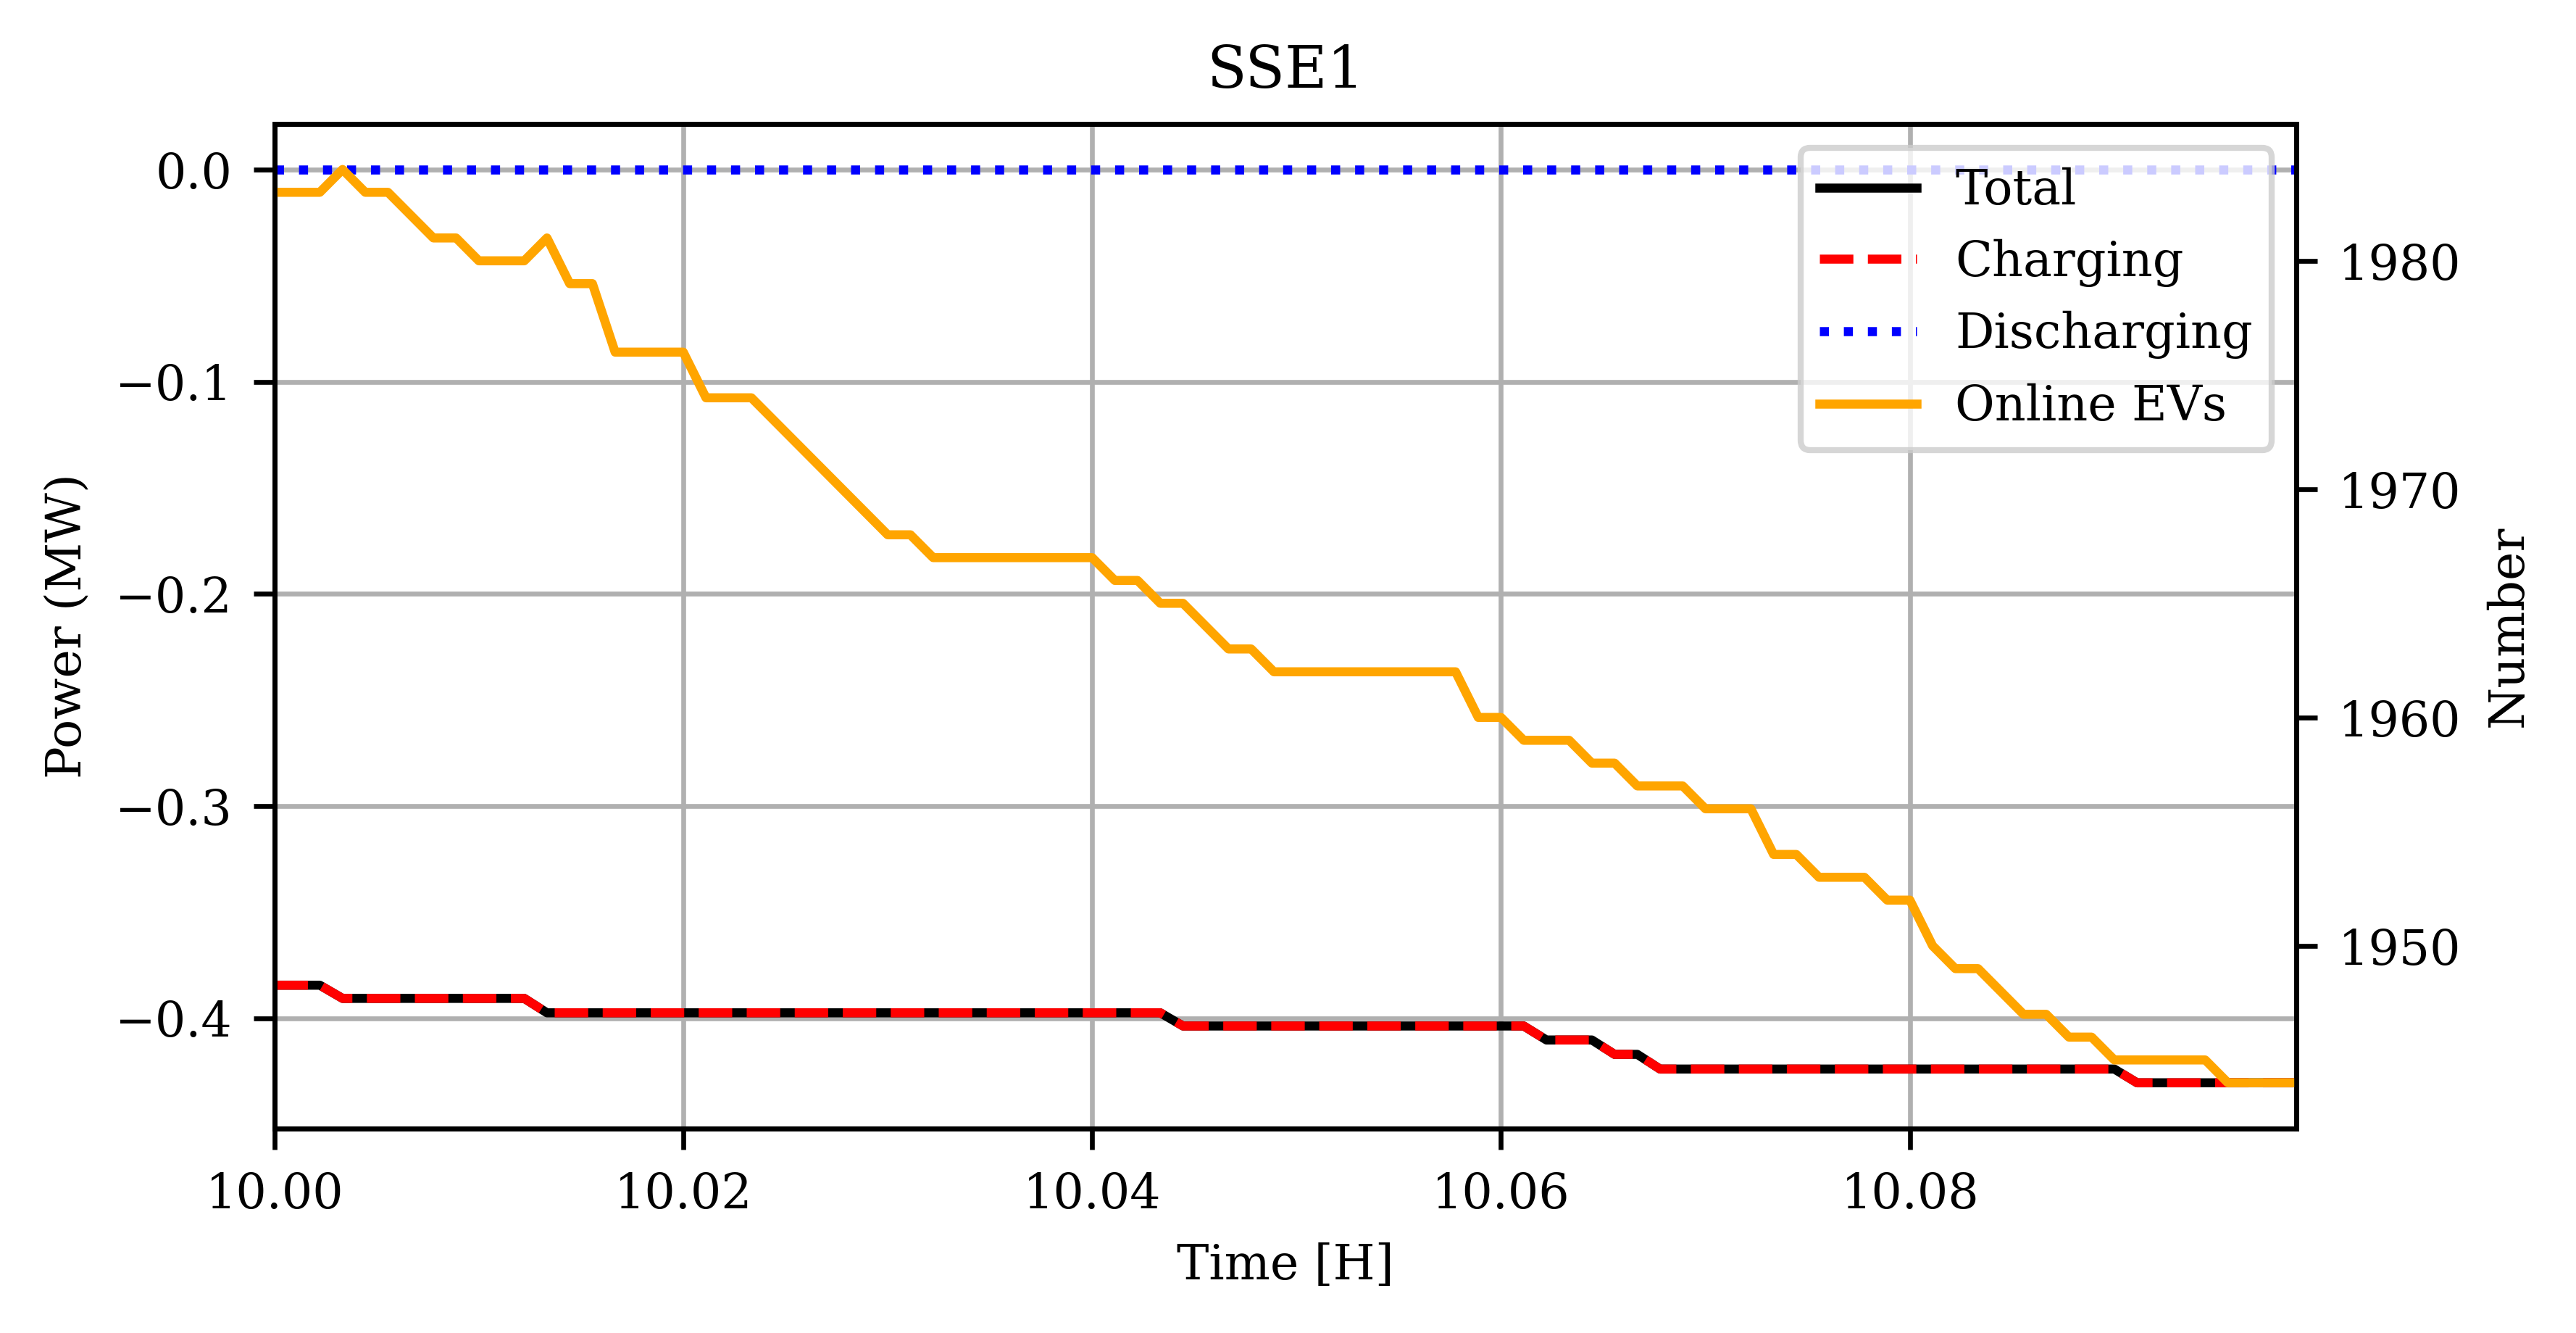

In [3]:
fig, ax = sse.plot()

In [ ]:
self = sse
# --- gather results ---
states = []
ctrls = []
for item in self.ev.xl.tolist():
    if len(item[0]) > 0:
        states.append(item[1][0])
        ctrls.append(item[0][0])
data = []
for x, y in zip(ctrls, states):
    data0 = []
    for c, s in zip(x, y):
        rx = c * self.Ns + s
        data0.append(rx)
    data.append(data0)

A0 = np.zeros((3*self.Ns, 3*self.Ns))
for d in data:
    for i in range(len(d)-1):
        A0[d[i+1], d[i]] += 1

In [ ]:
sse.ev.c.value_counts()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=100)
ax.spy(sse.A, markersize=5, marker='o',
       markerfacecolor='orange', markeredgecolor='orange')
ax.grid(which='major', alpha=1)
ax.grid(which='minor', alpha=1)
ax.set_xlim(0, 3*sse.Ns-1)
ax.set_ylim(3*sse.Ns-1, 0)
ax.set_title("Spy state transition matrix $A$")
ax.minorticks_on()

In [ ]:
sse.ev[sse.ev.c2 != sse.ev.c0]

In [ ]:
sse.ev.c.value_counts()

In [ ]:
sse.ev[sse.ev.c==1].bd

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
np.sign(0.1)

In [ ]:
evd = sse.ev.copy()
evd['sg'] = evd[['soc', 'socd', 'u']].apply(lambda x: np.sign(x[2] * (x[0] - x[1])), axis=1)

In [ ]:
sse.report()

In [ ]:
print(sse.cp()[0:3])
print(sse.ep()[0:3])

In [ ]:
[Pt, Pu, Pl, Pa, Pb, Pc, Pd] = sse.ep()

In [ ]:
Pa

In [ ]:
Pb

In [ ]:
Pc

In [ ]:
Pd

In [ ]:
cl = -1*sse.rtab.iloc[1].values - sse.rtab.iloc[2].values
cu = sse.rtab.iloc[0].values + sse.rtab.iloc[1].values

u = np.zeros((20,))
v = np.zeros((20,))

# max output
u = sse.rtab.iloc[0].values
v = sse.rtab.iloc[1].values + sse.rtab.iloc[0].values

# min output
u = -1 * sse.rtab.iloc[1].values - sse.rtab.iloc[2].values
v = -1 * sse.rtab.iloc[2].values

res = sse.x0 + np.matmul(sse.B, u).reshape(-1) + np.matmul(sse.C, v).reshape(-1)

print("res check:", np.all(res >= 0))


width = 0.35
x = np.arange(len(sse.x0))
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.bar(x - 0.5*width, sse.x0, width, label="in", color='cyan')
ax.bar(x + 0.5*width, res, width, label="out", color='orange')
ax.set_xlim(0, 59)
ax.set_ylim(-0.0, 0.01)
ax.legend(['x0', 'x0+ctrl'])

In [ ]:
sse.ne*np.matmul(sse.D, res)[0]

In [ ]:
for tf in np.arange(10, 11, 4/3600):
    sse.run(tf=tf, is_update=True, is_record=True, is_test=False)

In [ ]:
sse.ev.c.value_counts()

In [ ]:
sse.ev.Pc*sse.ev.c

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=200)
ax.spy(sse.A, markersize=5, marker='o',
       markerfacecolor='orange', markeredgecolor='orange')
ax.grid(which='major', alpha=1)
ax.grid(which='minor', alpha=1)
ax.set_xlim(0, 3*sse.Ns-1)
ax.set_ylim(3*sse.Ns-1, 0)
ax.set_title("Spy state transition matrix $A$")
ax.minorticks_on()

In [ ]:
sse.A[:,10]

In [ ]:
# --- plot online EV numbers ---
sse = ev_ssm(N=10000, ts=0, name='SSE0', seed=2022)
time = np.arange(0, 24, 0.1)
num = []
for t in time:
    sse.ts = sse.g_ts(t)
    sse.g_u()
    num.append(sse.ne)

fig, ax = plt.subplots()
ax.plot(time, num)
ax.set_title('Number of online EVs')
ax.set_xlabel('Time [h]')
ax.legend(['Online EV', 'Online capacity'])
ax.set_xlim(0, 24)

In [ ]:
# # --- plot online EV numbers ---
# # time = np.arange(0, 24, 0.1)
# # num = []
# # for t in time:
# #     sse.g_u(t)
# #     num.append(sse.ne)

# # fig, ax = plt.subplots()
# # ax.plot(time, num)
# # ax.set_title('Number of online EVs')
# # ax.set_xlabel('Time [h]')
# # ax.legend(['Online EV', 'Online capacity'])
# # ax.set_xlim(0, 24)

# # update g_x()

# # # reset sse
# # sse.reset(tnow=10)
# # sse.ev

# # --- Analytical method ---
# data = sse.ev.copy()
# data['dsc'] = data.Pc * data.nc / data.Q / 6
# data['dsd'] = data.Pc * data.nc / data.Q / 1
# data[['dsc', 'dsd']].plot(kind='kde')

# kde = stats.gaussian_kde(data.dsc)
# for i in range(-1,18,1):
#     lb = 0.05+0.05*i
#     ub = 0.1+0.05*i
#     ires = kde.integrate_box(lb, ub)
#     # print(np.round(ires, 4))

In [ ]:
# xdf = pd.DataFrame(xres)
# from hmmlearn import hmm
# gen_model = hmm.GaussianHMM(n_components=60, covariance_type="full")


# sse.reset(tnow=0)
# xres = []
# xres.append(sse.x.values())
# for t in np.arange(0, 24, 300/3600):
#     sse.act(t=300, tnow=t)
#     xres.append(sse.x.values())
# xdf = pd.DataFrame(xres)


# gen_model.fit(pd.concat([xdf]*100).reset_index(drop=True))
# gen_model.predict_proba(xdf.iloc[2].values.reshape(1, -1))

In [ ]:
# get the x res by iterate EV from t=0 to t=14.01
# sse.reset(tnow=0)
# x_res = []
# for i, t in enumerate(np.arange(0, 14.01, 1/12)):
#     sse.act(t=300, tnow=t)
#     x_res.append(sse.x.tolist())

# pd.DataFrame(x_res).plot(legend=True)

## Simulation

Issues: how to integerate the SSM when using ADNES?

flow_chart:
```{python}
prep grid data:
ADNES: topology,  gen. limits, ramp. limits, line limits,
Outside: gen. cost, ramp. cost,

for $t_{OPF}$ in T (interval: 5min; total: 1h; [n=12]):
    aggregate EV data (from SSM), generate $PR_{e,i,u,t}$
    Do OPF, generate $PG_{i, t}$, $PR_{g, i, u, t}$, $PR_{g, i, d, t}$

    for t in $t_{OPF}$ (interval: 4s; total: 5min; [n=75]):
        Update data into dynamic system:
            # Note, constant power model should be used in TDS.
            # Use TimeSeries as the load. 
            power change: TGOV1.paux0
            load change: 

        Run TDS: generate SFR mileage
```

Co-Sim list:
```{python}
for $t_{OPF}$ in T:
    EVA report $pru_{max}$ $prd_{max}$, eqn xxx
    TCC do OPF, eqn xxx
    Assign dispatch signal to generation units

    for t in $t_{AGC}$:
        Assign AGC signal to AGC units
        Run TDS
```